In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
#import library
import csv
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
train_labels = []
train_images = []
test_labels = []
test_images = []

with open("/gdrive/My Drive/fer2013.csv") as csv_file:
  csv_reader = csv.reader(csv_file,delimiter=",")
  for row_id, row in enumerate(csv_reader):
    if row_id == 0:
      continue
    label = np.zeros(7)
    label[int(row[0])] = 1
    image = list(map(int,row[1].split(' ')))
    """
    fer2013.csv에서 각 row에 들어있는 데이터는 아래와 같다.
    row[0]:이 그림이 나타내는 감정 상태(ex angry, sad...)
    row[1]:이 그림의 pixel값들 ' '로 구분됨
    row[2]:이 데이터가 training이냐 test냐

    이를 이용해 label과 image데이터를 만든 다음에,
    그거를 해당하는 배열에 넣음
    """
    if row[2] == 'Training':
      train_labels.append(label)
      train_images.append(image)
    elif row[2] == 'Testing':
      test_labels.append(label)
      test_images.append(image)

In [0]:
#train_data 재가공
train_labels = np.asarray(train_labels,dtype='float32')
train_images = np.asarray(train_images,dtype='float32').reshape(-1,48,48,1)

In [0]:
#test_data 재가공
test_labels = np.asarray(test_labels,dtype='float32')
test_images = np.asarray(test_images,dtype='float32').reshape(-1,48,48,1)

In [0]:
# normalization
train_images /= 255
test_images /= 255

In [0]:
#감정 mapping
emotions = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

Label array [0. 0. 0. 1. 0. 0. 0.] 
Emotion Happy 
Image shape (48, 48, 1)


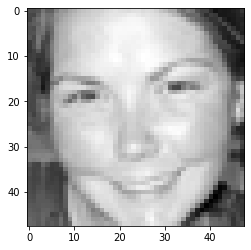

In [8]:
#train_data 일부 확인
index = 8
print('Label array',
      train_labels[index],
      '\nEmotion',
      emotions[np.argmax(train_labels[index])],
      '\nImage shape',
      train_images[index].shape)
plt.imshow(train_images[index].reshape(48,48),cmap='gray')
plt.show()

Label array [0. 0. 0. 1. 0. 0. 0.] 
Emotion Happy 
Image shape (48, 48, 1)


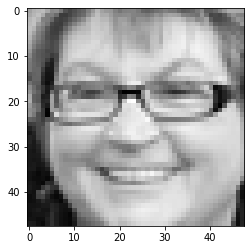

In [9]:
#test_data 일부 확인
index = 100
print('Label array',
      test_labels[index],
      '\nEmotion',
      emotions[np.argmax(test_labels[index])],
      '\nImage shape',
      test_images[index].shape)
plt.imshow(test_images[index].reshape(48,48),cmap='gray')
plt.show()

In [10]:
"""
모델 생성
이미지를 이용할 것이므로 convolution model 채택
layer가 깊어질 수록 학습이 제대로 안 될수도 있으므로 dropout같은 것을 수행
convolution과 maxpooling이 끝나면 거기에서 나온 것을 label과 대응 시키기 위해 dense layer사용
그래서 이미지 하나가 0~6사이의 값으로 대응됨 
"""
num_features = 64
num_labels = 7
model = Sequential()
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1),data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_labels, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 23, 23, 128)      

In [0]:
#model을 사용하기 전에 compile
model.compile(loss=categorical_crossentropy,
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [12]:
#model training
history = model.fit(train_images, train_labels,
                    batch_size=512,
                    epochs=50,
                    validation_data=(test_images, test_labels))

Train on 28709 samples, validate on 7178 samples
Epoch 1/50
28709/28709 [==============================] - 64s 2ms/step - loss: 2.1274 - accuracy: 0.2025 - val_loss: 1.8752 - val_accuracy: 0.2471
Epoch 2/50
28709/28709 [==============================] - 50s 2ms/step - loss: 1.8691 - accuracy: 0.2236 - val_loss: 1.8551 - val_accuracy: 0.2471
Epoch 3/50
28709/28709 [==============================] - 50s 2ms/step - loss: 1.8427 - accuracy: 0.2389 - val_loss: 1.8383 - val_accuracy: 0.2471
Epoch 4/50
28709/28709 [==============================] - 50s 2ms/step - loss: 1.8299 - accuracy: 0.2394 - val_loss: 1.8307 - val_accuracy: 0.2471
Epoch 5/50
28709/28709 [==============================] - 50s 2ms/step - loss: 1.8054 - accuracy: 0.2567 - val_loss: 1.8976 - val_accuracy: 0.2471
Epoch 6/50
28709/28709 [==============================] - 50s 2ms/step - loss: 1.7533 - accuracy: 0.2898 - val_loss: 1.8064 - val_accuracy: 0.2476
Epoch 7/50
28709/28709 [==============================] - 51s 2ms/ste

In [13]:
#european test_data 를 사용해서 model 성능 확인
loss, accuracy = model.evaluate(test_images, test_labels, verbose=1)
print('Loss:', loss, '\nAccuracy:', accuracy * 100, '%')

7178/7178 [==============================] - 6s 842us/step
Loss: 1.0750520667780008 
Accuracy: 63.87572884559631 %


In [0]:
#google drive에서 직접하면 느리다 그래서 아예 여기다가 풀기 korean_dataset 이용 준비
!unzip -q "/gdrive/My Drive/Images.zip" -d "/Images" 

In [0]:
from skimage import transform,io
korean_images = []
with open("/gdrive/My Drive/korean_face_dataset_12171708.csv") as csv_file:
  csv_reader = csv.reader(csv_file,delimiter=",")
  for row_id, row in enumerate(csv_reader):
    if row_id == 0:
      continue
    image = io.imread("/Images/Images/"+row[1], as_gray=True)
    grayscale_image =  transform.resize(image, (48,48), mode='symmetric')
    korean_images.append(grayscale_image)
    """
    korean dataset 부르기
    이때 이 데이터들은 색상이 컬러이고, 크기도 다르므로 가공이 필요함.
    가공된 결과는 48*48의 고정된 크기를 가지며 색상은 흑백만이 존재함.
    """

In [0]:
#korean_dataset 재가공
korean_images = np.asarray(korean_images,dtype='float32').reshape(-1,48,48,1)

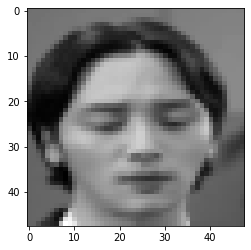

In [17]:
#korean_dataset확인
index = 203
plt.imshow(korean_images[index].reshape(48,48),cmap='gray')
plt.show()

In [0]:
#korean_dataset 예상하기
pred = np.argmax(model.predict(korean_images), axis=1)

In [0]:
#submission 준비
import pandas as pd
submission = pd.read_csv('/gdrive/My Drive/korean_face_dataset_12171708.csv')

In [0]:
#submission에 예상값 넣기
submission['Emotion'] = pred

In [21]:
#submission 확인
submission

,Emotion,File
0,6,misaeng.s1.e0001.sc0001.00000580.00.png
1,3,misaeng.s1.e0001.sc0001.00000930.01.png
2,4,misaeng.s1.e0001.sc0013.00000470.00.png
3,4,misaeng.s1.e0001.sc0013.00000610.00.png
4,6,misaeng.s1.e0001.sc0013.00001570.00.png
...,...,...
596,6,misaeng.s1.e0011.sc0074.00000330.00.png
597,4,misaeng.s1.e0011.sc0075.00000560.00.png
598,6,misaeng.s1.e0011.sc0075.00000580.00.png
599,6,misaeng.s1.e0011.sc0075.00000610.00.png


In [34]:
for i in range(7):
  print(emotions[i]+":"+str(np.count_nonzero(pred==i)))

Angry:62
Disgust:0
Fear:14
Happy:70
Sad:230
Surprise:2
Neutral:223


In [41]:
emotionscnt = np.zeros(7)
for train_label in train_labels:
  idx = np.argmax(train_label)
  emotionscnt[idx] = emotionscnt[idx]+1
for i in range(7):
  print(emotions[i]+":"+str(emotionscnt[i]))

Angry:3995.0
Disgust:436.0
Fear:4097.0
Happy:7215.0
Sad:4830.0
Surprise:3171.0
Neutral:4965.0


In [42]:
emotionscnt = np.zeros(7)
for test_label in test_labels:
  idx = np.argmax(test_label)
  emotionscnt[idx] = emotionscnt[idx]+1
for i in range(7):
  print(emotions[i]+":"+str(emotionscnt[i]))

Angry:958.0
Disgust:111.0
Fear:1024.0
Happy:1774.0
Sad:1247.0
Surprise:831.0
Neutral:1233.0


In [0]:
#submission 쓰기
submission.to_csv('/gdrive/My Drive/label_korean.csv', index = False)